<a href="https://colab.research.google.com/github/OptimizationExpert/Pyomo/blob/main/mrcpsp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyomo
from pyomo.environ import *
!apt-get install -y -qq coinor-cbc
opt= SolverFactory('cbc', executable='/usr/bin/cbc')

In [ ]:
activities = ['A', 'B']
modes = ['1', '2']
resources = ['R1']
times = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
durations = {('A', '1'): 3, ('A', '2'): 2, ('B', '1'): 4, ('B', '2'): 3} # duration for each activity in each mode
q = {('A', '1', 'R1'): 2, ('A', '2', 'R1'): 3, ('B', '1', 'R1'): 2, ('B', '2', 'R1'): 1}
B = {'R1': 4} # resource availability
P = [('A', 'B')]  # Precedence


activities = [a for a in range(8)]
modes = [1, 2]
resources = ['R1','R2']
times = [t for t in range(20)]
durations = {
    (0, 1): 0, (0, 2): 0,
    (1, 1): 3, (1, 2): 4,
    (2, 1): 2, (2, 2): 4,
    (3, 1): 2, (3, 2): 3,
    (4, 1): 2, (4, 2): 2,
    (5, 1): 3, (5, 2): 3,
    (6, 1): 4, (6, 2): 6,
    (7, 1): 0, (7, 2): 0
}
B = {'R1': 3, 'R2':15}
P = [(0,1), (0,2), (1,3), (3,5),(2,4), (4,6),(5,7), (6,7)]  # Precedence
q  = {
    (0, 1, 'R1'): 0, (0, 1, 'R2'): 0,
    (1, 1, 'R1'): 2, (1, 1, 'R2'): 5,
    (1, 2, 'R1'): 1, (1, 2, 'R2'): 1,
    (2, 1, 'R1'): 3, (2, 1, 'R2'): 6,
    (2, 2, 'R1'): 3, (2, 2, 'R2'): 2,
    (3, 1, 'R1'): 4, (3, 1, 'R2'): 2,
    (3, 2, 'R1'): 2, (3, 2, 'R2'): 2,
    (4, 1, 'R1'): 3, (4, 1, 'R2'): 6,
    (4, 2, 'R1'): 4, (4, 2, 'R2'): 4,
    (5, 1, 'R1'): 3, (5, 1, 'R2'): 1,
    (5, 2, 'R1'): 1, (5, 2, 'R2'): 7,
    (6, 1, 'R1'): 2, (6, 1, 'R2'): 1,
    (6, 2, 'R1'): 1, (6, 2, 'R2'): 1,
    (7, 1, 'R1'): 0, (7, 1, 'R2'): 0,
}






In [ ]:

model = ConcreteModel()

# Sets
model.I = Set(initialize=activities)  # Activities
model.M = Set(initialize=modes)  # Modes
model.R = Set(initialize=resources)      # Resources
model.T = Set(initialize=times)   # Time horizon

model.IMT = Set(initialize=[(i, m, t) for i in model.I for m in model.M for t in model.T])
model.IM = Set(initialize=[(i, m) for i in model.I for m in model.M])
model.IR = Set(initialize=[(i, r) for i in model.I for r in model.R])
model.IMR = Set(initialize=[(i, m, r) for i in model.I for m in model.M for r in model.R])



model.d = Param(model.IM, initialize=durations)

model.q = Param(model.IMR, initialize={(i, m, r): q.get((i, m, r), 0) for i in model.I for m in model.M for r in model.R})
model.B = Param(model.R, initialize=B)

# Decision Variables
model.x = Var(model.IMT, initialize=0,domain=Binary)
model.Cmax = Var(domain=NonNegativeReals)

# One mode and one start time per activity
def one_start_rule(model, i):
    return sum(model.x[i, m, t] for m in model.M for t in model.T if t <= max(model.T) - model.d[i, m]) == 1
model.OneStart = Constraint(model.I, rule=one_start_rule)

# Precedence constraints
model.Precedence = ConstraintList()
for (i, j) in P:
    model.Precedence.add(
        sum((t + model.d[i, m]) * model.x[i, m, t] for m in model.M for t in model.T if t <= max(model.T) - model.d[i, m])
        <= sum(t * model.x[j, m, t] for m in model.M for t in model.T if t <= max(model.T) - model.d[j, m])
    )

# Resource constraints
def resource_rule(model, r, tau):
    expressions = [model.q[i, m, r] * model.x[i, m, t]
        for i in model.I for m in model.M for t in model.T
        if t <= tau < t + model.d[i, m] and t <= max(model.T) - model.d[i, m]]
    expr = sum(expressions)
    if len(expressions) == 0:
        return Constraint.Skip
    return expr <= model.B[r]
model.ResourceCap = Constraint(model.R, model.T, rule=resource_rule)

# Makespan
def makespan_rule(model, i):
    return sum((t + model.d[i, m]) * model.x[i, m, t]
               for m in model.M for t in model.T if t <= max(model.T) - model.d[i, m]) <= model.Cmax
model.Makespan = Constraint(model.I, rule=makespan_rule)

# Objective
model.Obj = Objective(expr=model.Cmax, sense=minimize)

# Solver (optional)
opt.solve(model, tee=False)

# Display solution (optional)
#model.display()

solution = []
for (i,m,t) in model.x:
  if value(model.x[i, m, t]) > 0.5:
      dur = value(model.d[i, m])
      solution.append((i, m, t, dur))

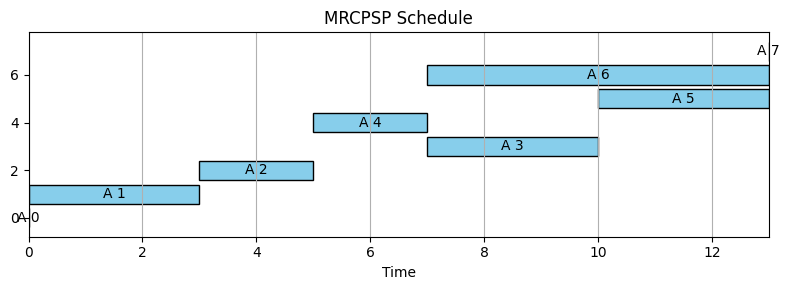

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Simulated output: list of (activity, selected mode, start time, duration)
# Replace this with actual values from your Pyomo model
# Build a DataFrame
df = pd.DataFrame(solution, columns=['Activity', 'Mode', 'Start', 'Duration'])
df['Finish'] = df['Start'] + df['Duration']

# Plot Gantt chart
fig, ax = plt.subplots(figsize=(8, 3))
for idx, row in df.iterrows():
    ax.barh(row['Activity'], row['Duration'], left=row['Start'], color='skyblue', edgecolor='black')
    ax.text(row['Start'] + row['Duration'] / 2, idx, f"A {row['Activity']}",
            va='center', ha='center', color='black', fontsize=10)

ax.set_xlabel("Time")
ax.set_title("MRCPSP Schedule")
ax.grid(True, axis='x')
plt.tight_layout()
plt.show()